In [16]:
import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import os

#### Data

In [4]:
img_height, img_width, img_channels = 180, 180, 3
batch_size=32
data_dir = '../data/external/images/training'
test_data_dir = '../data/external/images/testing'
loading_dataste_seed = 0

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
classes = train_data.class_names

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


#### Flip detection model

In [5]:
inputs = Input(shape= (img_height, img_width, img_channels))
layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
layer2 = MaxPooling2D((2,2))(layer1)
layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(layer2)
layer4 = MaxPooling2D((2,2))(layer3)
layer5 = Flatten()(layer4)
layer6 = Dense(64, activation='relu')(layer5)
outputs = Dense(len(classes), activation='softmax')(layer6)
fd_model = Model(inputs=inputs, outputs=outputs)

fd_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
fd_model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 59168)             0  

In [4]:
fd_model_hist = fd_model.fit(train_data, epochs=10, validation_data = val_data)

Epoch 1/10


60/60 [==============================] - 12s 178ms/step - loss: 123.5604 - accuracy: 0.6191 - val_loss: 0.5664 - val_accuracy: 0.7176
Epoch 2/10
60/60 [==============================] - 12s 192ms/step - loss: 0.4408 - accuracy: 0.7847 - val_loss: 0.3260 - val_accuracy: 0.8368
Epoch 3/10
60/60 [==============================] - 12s 197ms/step - loss: 0.1567 - accuracy: 0.9404 - val_loss: 0.1511 - val_accuracy: 0.9456
Epoch 4/10
60/60 [==============================] - 12s 197ms/step - loss: 0.0670 - accuracy: 0.9807 - val_loss: 0.1542 - val_accuracy: 0.9331
Epoch 5/10
60/60 [==============================] - 12s 200ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.0959 - val_accuracy: 0.9665
Epoch 6/10
60/60 [==============================] - 12s 197ms/step - loss: 0.0273 - accuracy: 0.9953 - val_loss: 0.0637 - val_accuracy: 0.9707
Epoch 7/10
60/60 [==============================] - 12s 196ms/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0693 - val_accuracy: 0.

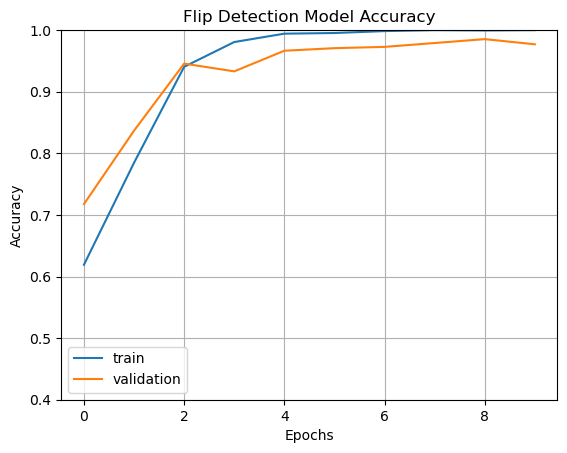

In [5]:
plt.plot(fd_model_hist.history['accuracy'])
plt.plot(fd_model_hist.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Flip Detection Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

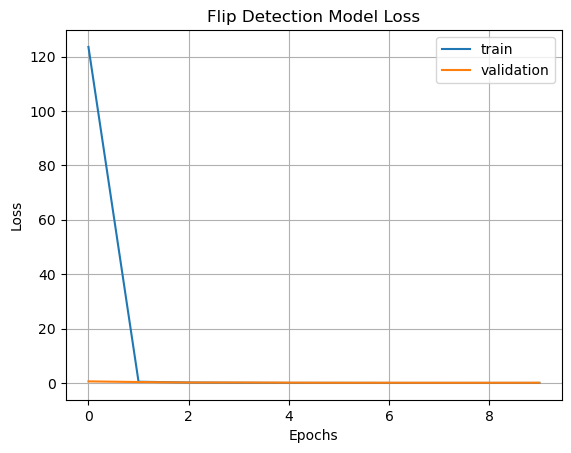

In [6]:
plt.plot(fd_model_hist.history['loss'])
plt.plot(fd_model_hist.history['val_loss'])
plt.grid()
plt.title('Flip Detection Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import seaborn as sns

def evaluate_model(model, test_data):
    results = {}    
    predicted_labels = []
    true_labels = []
    all_images = []
    for images, labels in test_data:
        true_labels.extend(labels.numpy())
        predicted_labels.extend(tf.argmax(model.predict(images), axis=1).numpy())

    # Accuracy
    results['accuracy'] = accuracy_score(true_labels, predicted_labels)
    
    # F1 Score
    results['f1_score'] = f1_score(true_labels, predicted_labels)
        
    cm = confusion_matrix(true_labels, predicted_labels)
    
    class_names = test_data.class_names
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return results

1/1 [==============================] - 0s 78ms/step


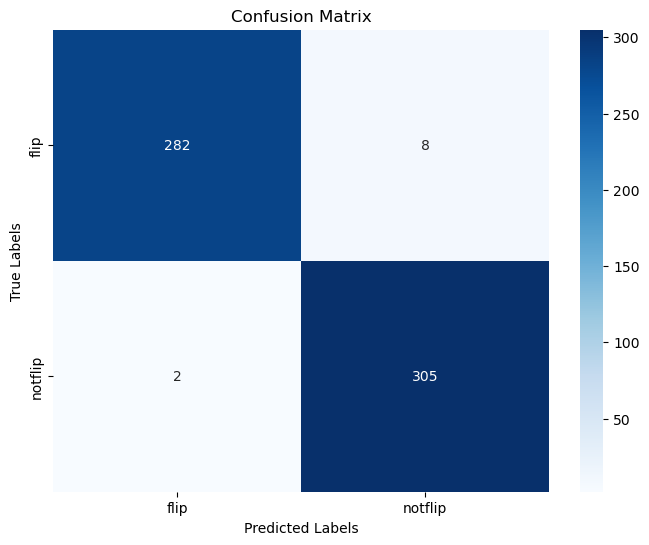

{'accuracy': 0.983249581239531, 'f1_score': 0.9838709677419355}

In [8]:
evaluate_model(fd_model, test_data)

In [9]:
fd_model_path = '../models/fd_model.h5'
fd_model.save(fd_model_path)
fd_model_size = os.path.getsize(fd_model_path)/(1024 * 1024)
print('Model size: ', fd_model_size, 'MB')

Model size:  43.497314453125 MB


C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### VGG19 model

In [10]:
pre_trained_vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', classifier_activation=None, classes=len(classes))

for layer in pre_trained_vgg_model.layers:
    layer.trainable = False
    layer1 = pre_trained_vgg_model(inputs)
    layer2 = Flatten()(layer1)
    layer3 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer2)
    outputs = Dense(len(classes), activation='softmax')(layer3)
    vgg_model = Model(inputs=inputs, outputs=outputs)

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_22 (Flatten)        (None, 12800)             0         
                                                                 
 dense_44 (Dense)            (None, 512)               6554112   
                                                                 
 dense_45 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 26579522 (101.39 MB)
Trainable params: 6555138 (25.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [11]:
vgg_model_hist = vgg_model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
60/60 [==============================] - 181s 3s/step - loss: 11.3888 - accuracy: 0.8396 - val_loss: 3.5546 - val_accuracy: 0.9833
Epoch 2/5
60/60 [==============================] - 188s 3s/step - loss: 2.9665 - accuracy: 0.9927 - val_loss: 2.4706 - val_accuracy: 0.9937
Epoch 3/5
60/60 [==============================] - 190s 3s/step - loss: 2.1339 - accuracy: 0.9974 - val_loss: 1.8460 - val_accuracy: 0.9958
Epoch 4/5
60/60 [==============================] - 190s 3s/step - loss: 1.6227 - accuracy: 0.9995 - val_loss: 1.4327 - val_accuracy: 0.9958
Epoch 5/5
60/60 [==============================] - 191s 3s/step - loss: 1.2721 - accuracy: 1.0000 - val_loss: 1.1438 - val_accuracy: 0.9958


1/1 [==============================] - 2s 2s/step


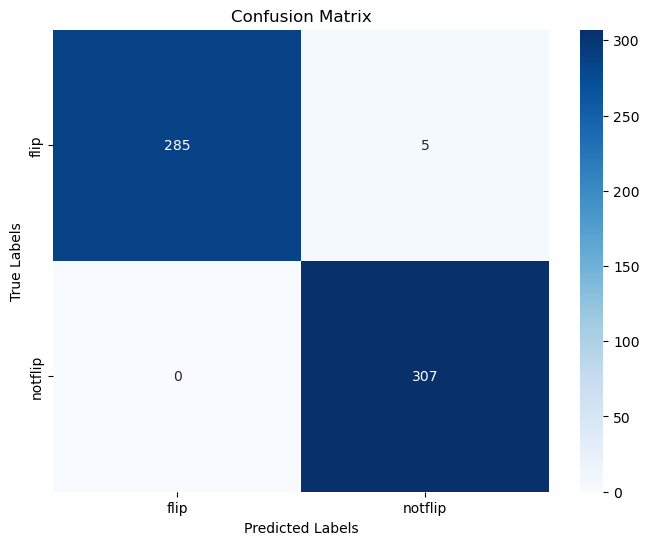

{'accuracy': 0.9916247906197655, 'f1_score': 0.9919224555735056}

In [12]:
evaluate_model(vgg_model, test_data)

In [13]:
vgg19_model_path = '../models/vgg19_model.h5'
vgg_model.save(vgg19_model_path)
vgg19_model_size = os.path.getsize(vgg19_model_path) / (1024 * 1024)
print('Model size: ', vgg19_model_size, 'MB')

Model size:  151.4839859008789 MB


C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### ResNet Model

In [14]:
pre_trained_resnet_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', classifier_activation=None, classes=len(classes))

for layer in pre_trained_resnet_model.layers:
    layer.trainable = False
    layer1 = pre_trained_resnet_model(inputs)
    layer2 = Flatten()(layer1)
    layer3 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer2)
    outputs = Dense(len(classes), activation='softmax')(layer3)
    resnet_model = Model(inputs=inputs, outputs=outputs)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "model_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten_197 (Flatten)       (None, 73728)             0         
                                                                 
 dense_394 (Dense)           (None, 512)               37749248  
                                                                 
 dense_395 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 61337986 (233.99 MB)
Trainable params: 37750274 (144.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_______

In [15]:
resnet_model_hist = resnet_model.fit(
  train_data,
  validation_data=val_data,
  epochs=5
)

Epoch 1/5
60/60 [==============================] - 89s 1s/step - loss: 13.4735 - accuracy: 0.8595 - val_loss: 4.3171 - val_accuracy: 0.9226
Epoch 2/5
60/60 [==============================] - 83s 1s/step - loss: 2.8744 - accuracy: 0.9807 - val_loss: 2.1120 - val_accuracy: 0.9770
Epoch 3/5
60/60 [==============================] - 83s 1s/step - loss: 1.7742 - accuracy: 0.9697 - val_loss: 1.6383 - val_accuracy: 0.9561
Epoch 4/5
60/60 [==============================] - 85s 1s/step - loss: 1.2548 - accuracy: 0.9791 - val_loss: 0.9187 - val_accuracy: 0.9874
Epoch 5/5
60/60 [==============================] - 84s 1s/step - loss: 0.8444 - accuracy: 0.9796 - val_loss: 0.7861 - val_accuracy: 0.9770


1/1 [==============================] - 1s 1s/step


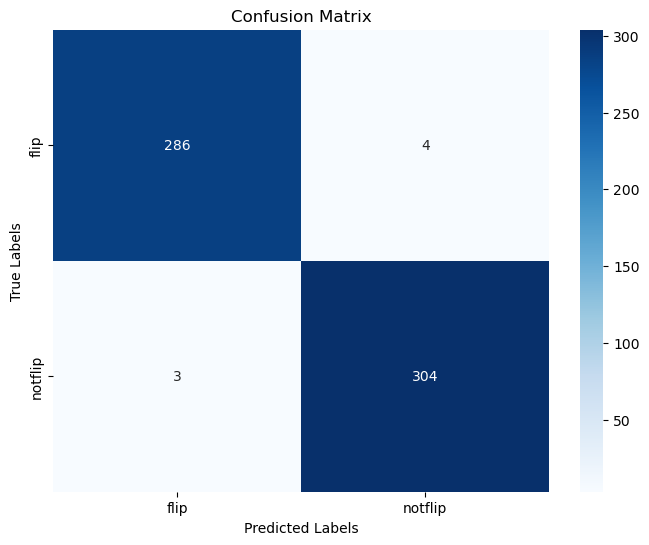

{'accuracy': 0.9882747068676717, 'f1_score': 0.9886178861788618}

In [16]:
evaluate_model(resnet_model, test_data)

In [17]:
resnet_model_path = '../models/resnet_model.h5'
resnet_model.save(resnet_model_path)
resnet_model_size = os.path.getsize(resnet_model_path) / (1024 * 1024)
print('Model size: ', resnet_model_size,  'MB')

C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model size:  522.3423233032227 MB


#### MobileNet

In [6]:
pre_trained_mobile_net_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', classifier_activation=None, classes=len(classes))

for layer in pre_trained_mobile_net_model.layers:
    layer.trainable = False
    layer1 = pre_trained_mobile_net_model(inputs)
    layer2 = Flatten()(layer1)
    layer3 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer2)
    outputs = Dense(len(classes), activation='softmax')(layer3)
    mobile_net_model = Model(inputs=inputs, outputs=outputs)

mobile_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mobile_net_model.summary()

Model: "model_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 flatten_154 (Flatten)       (None, 32000)             0         
                                                                 
 dense_308 (Dense)           (None, 512)               16384512  
                                                                 
 dense_309 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 18643522 (71.12 MB)
Trainable params: 16385538 (62.51 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [7]:
mobile_net_model_hist = mobile_net_model.fit(
  train_data,
  validation_data=val_data,
  epochs=10
)

Epoch 1/10


60/60 [==============================] - 24s 365ms/step - loss: 8.4367 - accuracy: 0.7665 - val_loss: 2.7130 - val_accuracy: 0.8347
Epoch 2/10
60/60 [==============================] - 21s 350ms/step - loss: 1.7982 - accuracy: 0.9368 - val_loss: 1.4033 - val_accuracy: 0.8912
Epoch 3/10
60/60 [==============================] - 21s 351ms/step - loss: 1.1563 - accuracy: 0.9357 - val_loss: 0.9185 - val_accuracy: 0.9707
Epoch 4/10
60/60 [==============================] - 22s 356ms/step - loss: 0.6984 - accuracy: 0.9916 - val_loss: 0.5881 - val_accuracy: 0.9791
Epoch 5/10
60/60 [==============================] - 22s 359ms/step - loss: 0.4751 - accuracy: 0.9979 - val_loss: 0.4375 - val_accuracy: 0.9770
Epoch 6/10
60/60 [==============================] - 22s 358ms/step - loss: 0.3537 - accuracy: 0.9990 - val_loss: 0.3874 - val_accuracy: 0.9644
Epoch 7/10
60/60 [==============================] - 22s 358ms/step - loss: 0.4073 - accuracy: 0.9566 - val_loss: 0.4099 - val_accuracy: 0.95

1/1 [==============================] - 1s 781ms/step


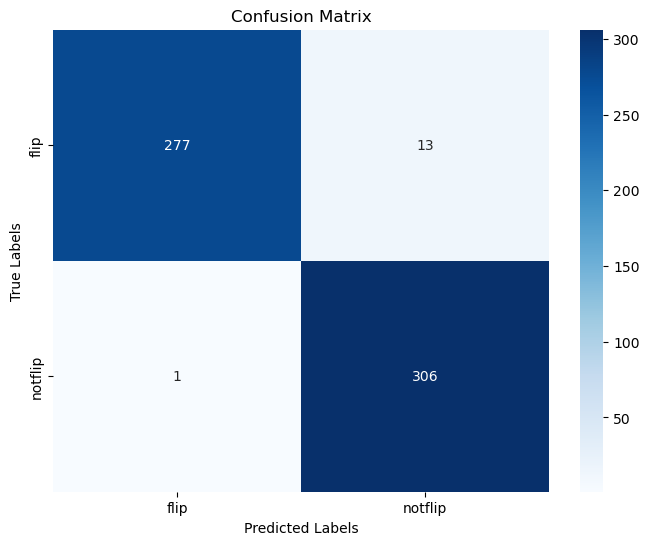

{'accuracy': 0.9765494137353434, 'f1_score': 0.9776357827476039}

In [10]:
evaluate_model(mobile_net_model, test_data)

In [11]:
mobile_net_model_path = '../models/mobile_net_model.h5'
mobile_net_model.save(mobile_net_model_path)
mobile_net_model_size = os.path.getsize(mobile_net_model_path) / (1024 * 1024)
print('Model size: ', mobile_net_model_size,  'MB')

C:\Users\KUDIPUDI\.conda\envs\dsEnv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model size:  196.45294952392578 MB
